In [ ]:
# Essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series Analysis
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_absolute_percentage_error

# Statistical Analysis
from scipy import stats
from scipy.stats import mstats
from scipy.stats.mstats import mquantiles
from scipy.stats import gaussian_kde

# **Load and Explore Data**


In [ ]:
df=pd.read_csv('https://raw.githubusercontent.com/kristxna/Datasets/refs/heads/main/data_set_hackathon.csv')

In [ ]:
df.head()

,order_date,requested_delivery_date,Customer Country Code,Product Code,Description,order_type,Customer Order Code,value,Curr,items,Route
0,13.07.2009,28.01.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435553,2337.00,RUB,6,RU0001
1,15.07.2009,24.03.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435694,10160.25,RUB,23,RU0001
2,16.07.2009,04.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435741,2992.50,RUB,7,RU0001
3,17.07.2009,04.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435907,4061.25,RUB,9,RU0001
4,21.07.2009,01.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435963,2208.75,RUB,5,RU0001


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_date               2420 non-null   object 
 1   requested_delivery_date  2420 non-null   object 
 2   Customer Country Code    2420 non-null   object 
 3   Product Code             2420 non-null   object 
 4   Description              2420 non-null   object 
 5   order_type               2420 non-null   object 
 6   Customer Order Code      2420 non-null   int64  
 7   value                    2420 non-null   float64
 8   Curr                     2420 non-null   object 
 9   items                    2420 non-null   object 
 10  Route                    2420 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 208.1+ KB


In [ ]:
print(df['order_type'].unique())

['VO']


# Data Cleaning & EDA

In [ ]:
# Convert 'order_date' and 'requested_delivery_date' to datetime
date_columns = ['order_date', 'requested_delivery_date']

for col in date_columns:
    df[col] = pd.to_datetime(df[col], format='%d.%m.%Y', errors='coerce')

In [ ]:
# Convert 'items' to numeric
df['items'] = pd.to_numeric(df['items'], errors='coerce')

In [ ]:
# Check for missing values
df.isnull().sum()

,0
order_date,0
requested_delivery_date,0
Customer Country Code,0
Product Code,0
Description,0
order_type,0
Customer Order Code,0
value,0
Curr,0
items,346


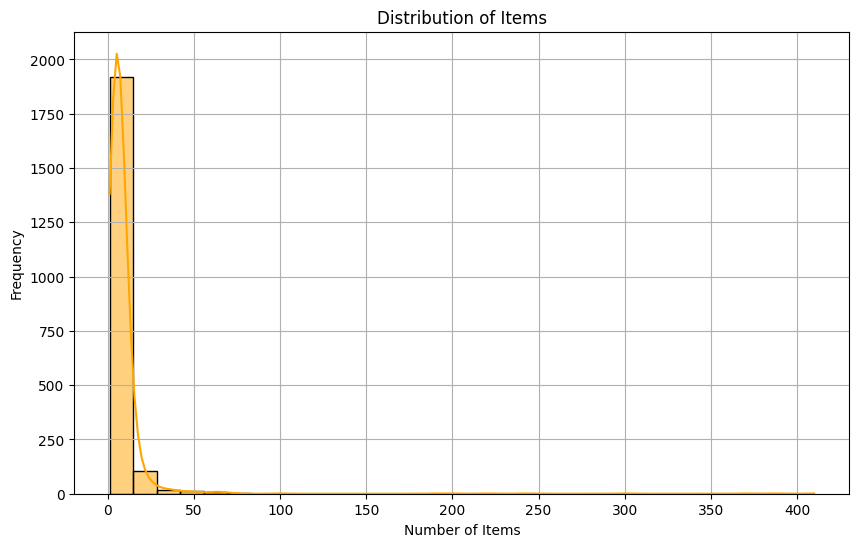

In [ ]:
# Check the distribution of 'items' column
plt.figure(figsize=(10, 6))
sns.histplot(df['items'], kde=True, bins=30, color='orange')
plt.title('Distribution of Items')
plt.xlabel('Number of Items')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# Summary statistics for 'items' column
df['items'].describe()

,items
count,2074.000000
mean,8.288814
std,19.637378
min,1.000000
25%,4.000000
50%,6.000000
75%,8.000000
max,410.000000


Will replace items nulls with median given the distribution.

In [ ]:
# Display rows where 'items' column is null
df[df['items'].isnull()]

,order_date,requested_delivery_date,Customer Country Code,Product Code,Description,order_type,Customer Order Code,value,Curr,items,Route
23,2009-09-07,2010-04-01,NL,L10705000,Parka Outdoor Lifestyle STD,VO,3200516115,0.0,EUR,NaN,BE0001
24,2009-09-08,2010-04-01,ES,L10705000,Parka Outdoor Lifestyle STD,VO,3200521379,0.0,EUR,NaN,SP0003
89,2009-08-03,2010-05-03,FR,L10705400,Parka Outdoor Lifestyle STD,VO,3200516117,0.0,EUR,NaN,FR0001
90,2009-08-27,2010-02-01,FR,L10705400,Parka Outdoor Lifestyle STD,VO,3200516182,0.0,EUR,NaN,FR0001
91,2009-10-06,2010-04-15,NL,L10705400,Parka Outdoor Lifestyle STD,VO,3200516289,0.0,EUR,NaN,BE0001
...,...,...,...,...,...,...,...,...,...,...,...
2393,2011-09-08,2012-06-30,FI,L12919200,Parka Outdoor Lifestyle STD,VO,3200746610,0.0,EUR,NaN,FI01FR
2396,2011-09-25,2012-05-01,FR,L12919200,Parka Outdoor Lifestyle STD,VO,3200757495,0.0,EUR,NaN,FR0001
2399,2011-09-27,2012-04-01,ES,L12919200,Parka Outdoor Lifestyle STD,VO,3200759344,0.0,EUR,NaN,SP0003
2400,2011-09-28,2012-03-01,IT,L12919200,Parka Outdoor Lifestyle STD,VO,3200759628,0.0,EUR,NaN,IT0000


When looking at the NaN values in the items column, we looked at the value column and saw that it was 0. Therefore, to handle the null values in items, we are also replacing the items with 0 rather than with a mean or median as we are inferring that these orders were either returned, voided or something occurred in which the order was not completed.

In [ ]:
# Replace null values in the 'items' column with 0
df['items'].fillna(0, inplace=True)

<ipython-input-12-c9afc737e8d2>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['items'].fillna(0, inplace=True)


In [ ]:
df.isnull().sum()

,0
order_date,0
requested_delivery_date,0
Customer Country Code,0
Product Code,0
Description,0
order_type,0
Customer Order Code,0
value,0
Curr,0
items,0


<ipython-input-14-2d3f011425df>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Customer Country Code', order=df['Customer Country Code'].value_counts().index, palette='viridis')


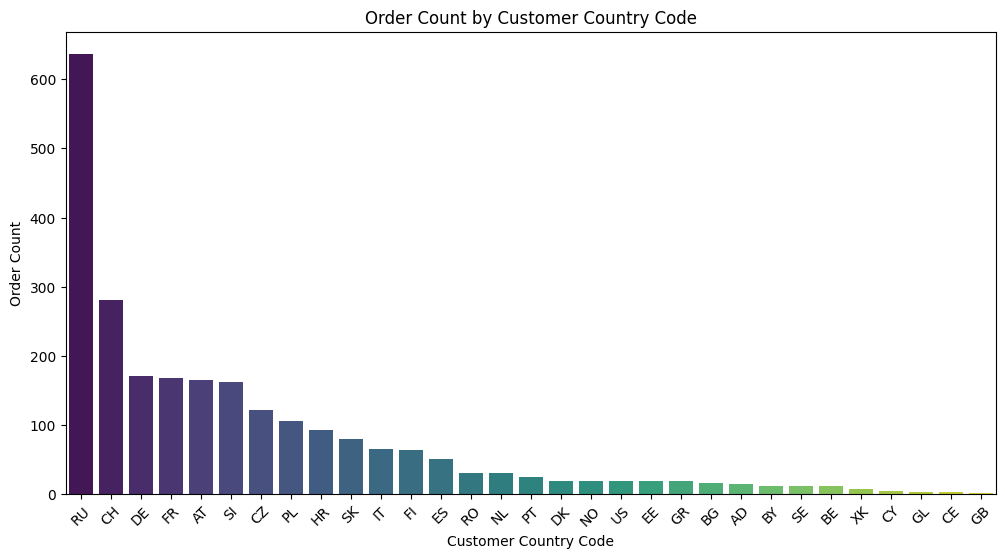

In [ ]:
# Orders by Customer Country Code
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Customer Country Code', order=df['Customer Country Code'].value_counts().index, palette='viridis')
plt.title('Order Count by Customer Country Code')
plt.xlabel('Customer Country Code')
plt.ylabel('Order Count')
plt.xticks(rotation=45)
plt.show()

# **Demand Forecasting Predictive Model**

# Uncertainty 1: Monthly Distinct Orders

**How many distinct orders are received in each month?**

Here we are creating a new column, Year-Month, by converting order_date to a monthly period format.

Then we're grouping the dataset by Year-Month to count the number of unique Customer Order Code values for each month and renaming the column to Distinct Orders for clarity.

In [ ]:
# Preprocess and Group Data for Distinct Orders
df['Year-Month'] = df['order_date'].dt.to_period('M')
monthly_orders = df.groupby('Year-Month')['Customer Order Code'].nunique().reset_index()
monthly_orders.rename(columns={'Customer Order Code': 'Distinct Orders'}, inplace=True)

In [ ]:
# Convert Year-Month to datetime for time series analysis
monthly_orders['Year-Month'] = monthly_orders['Year-Month'].astype(str)
monthly_orders['Year-Month'] = pd.to_datetime(monthly_orders['Year-Month'])

We've capped extreme values in Distinct Orders at the 95th percentile to reduce the effect of outliers.

In [ ]:
# Cap extreme values to the 95th percentile
cap_value = monthly_orders['Distinct Orders'].quantile(0.95)
monthly_orders['Capped Distinct Orders'] = np.where(
    monthly_orders['Distinct Orders'] > cap_value, cap_value, monthly_orders['Distinct Orders']
)

We are applying a log transformation to the capped Distinct Orders to stabilize variance and make the data more suitable for modelling.

In [ ]:
# Log transformation
monthly_orders['Log Distinct Orders'] = np.log1p(monthly_orders['Capped Distinct Orders'] + 1e-9)

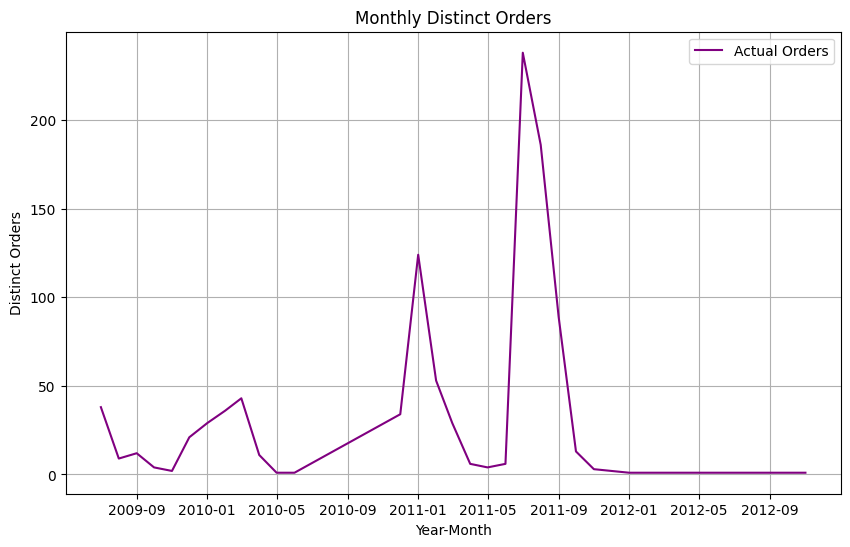

In [ ]:
# Time Series Visualization
plt.figure(figsize=(10, 6))
plt.plot(monthly_orders['Year-Month'], monthly_orders['Distinct Orders'], color='purple', label='Actual Orders')
plt.xlabel('Year-Month')
plt.ylabel('Distinct Orders')
plt.title('Monthly Distinct Orders')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Distinct Orders by Month
monthly_orders['Year Month'] = monthly_orders['Year-Month'].dt.strftime('%Y-%m')
print("Distinct Orders by Month:")
print(monthly_orders[['Year Month', 'Distinct Orders']])

Distinct Orders by Month:
   Year Month  Distinct Orders
0     2009-07               38
1     2009-08                9
2     2009-09               12
3     2009-10                4
4     2009-11                2
5     2009-12               21
6     2010-01               29
7     2010-02               36
8     2010-03               43
9     2010-04               11
10    2010-05                1
11    2010-06                1
12    2010-12               34
13    2011-01              124
14    2011-02               53
15    2011-03               29
16    2011-04                6
17    2011-05                4
18    2011-06                6
19    2011-07              238
20    2011-08              186
21    2011-09               89
22    2011-10               13
23    2011-11                3
24    2012-01                1
25    2012-04                1
26    2012-11                1


We can see in the table of monthly distinct orders, there are order peaks and troughs. There may be a seasonal trend.

Here, we are doing seasonal decomposition to identify and highlight any potential seasonal trends in the data.

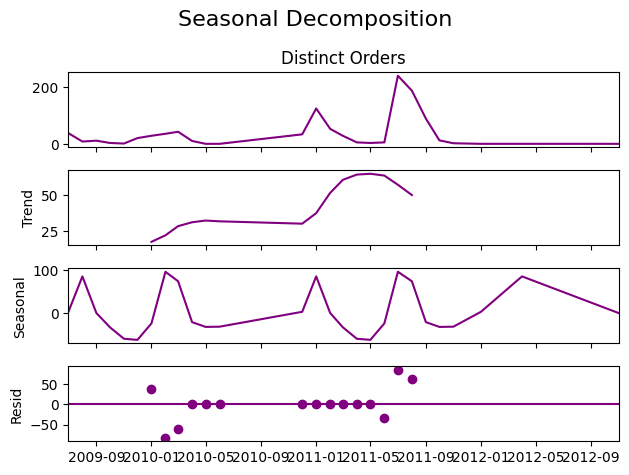

In [ ]:
# Seasonal Decomposition
if 'Year-Month' not in monthly_orders.columns:
    monthly_orders['Year-Month'] = monthly_orders.index
monthly_orders.set_index('Year-Month', inplace=True)

decompose_result = seasonal_decompose(monthly_orders['Distinct Orders'], model='additive', period=12)
axes = decompose_result.plot().axes
for ax in axes:
    for line in ax.get_lines():
        line.set_color('purple')
plt.suptitle('Seasonal Decomposition', fontsize=16)
plt.tight_layout()
plt.show()

Based on the decomposition, this confirms seasonality with periodic peaks and dips, showing a clear seasonal component and some residual variation.

We are plotting the Autocorrelation Function to identify repeating patterns in the data, as well as the Partial Autocorrelation Function to assess the direct relationships between lags.

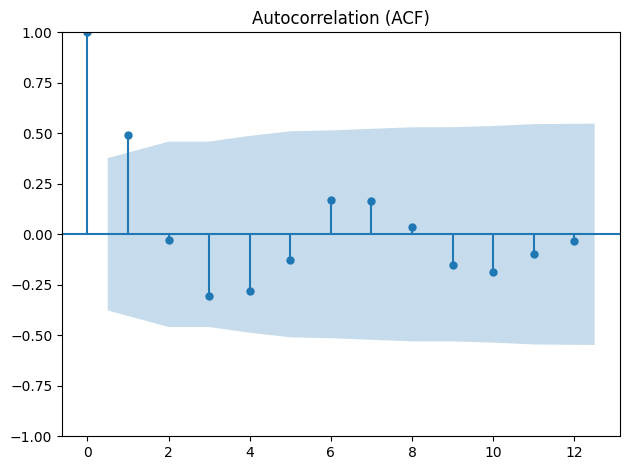

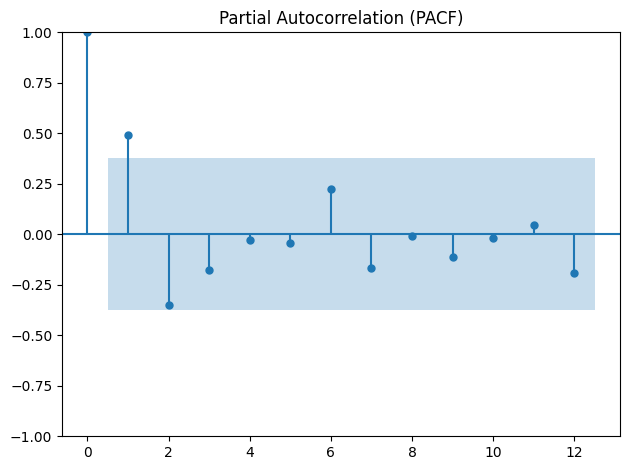

In [ ]:
# Plot ACF and PACF
plot_acf(monthly_orders['Distinct Orders'], lags=12)
plt.title('Autocorrelation (ACF)')
plt.tight_layout()
plt.show()

plot_pacf(monthly_orders['Distinct Orders'], lags=12)
plt.title('Partial Autocorrelation (PACF)')
plt.tight_layout()
plt.show()


**Autocorrelation (ACF)**:
The ACF plot indicates a strong correlation at lag 1 and moderate correlations at other lags, suggesting some predictable patterns in the data.

**Partial Autocorrelation (PACF)**:
The PACF plot supports using an AR(1) model, as the lag-1 partial autocorrelation is significant, while others diminish.

Based on the results of the seasonal decomposition and autocorrelation, we will use a SARIMA model as there is evidence of seasonality in the data.

Additionally, we can see in the seasonal decomposition patterns and the autocorrelation spikes that there may be quarterly seasonality, therefore will use quarterly seasonality in the SARIMA model rather than monthly.

In [ ]:
# Train-Test Split
train = monthly_orders.iloc[:-5]  # Use all but the last 5 months for training
test = monthly_orders.iloc[-5:]   # Use the last 5 months for testing

In [ ]:
# SARIMA Model Fitting
sarima_model = SARIMAX(
    monthly_orders['Distinct Orders'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 4)  # Quarterly seasonality
)
sarima_result = sarima_model.fit(disp=False)

print(sarima_result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


                                     SARIMAX Results                                     
Dep. Variable:                   Distinct Orders   No. Observations:                   27
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                -124.861
Date:                           Mon, 09 Dec 2024   AIC                            259.723
Time:                                   19:21:49   BIC                            265.178
Sample:                                        0   HQIC                           261.008
                                            - 27                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9984    179.030      0.006      0.996    -349.894     351.891
ma.L1         -0.9978    123.608     -0.008

Now we will forecast the next 5 months using the SARIMA model.

We'll use the predicted mean values for the test period and calculate the confidence intervals for the forecasted values.

In [ ]:
# Forecast and Evaluate
forecast = sarima_result.get_forecast(steps=5)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
# Forecast Future 5 Months
future_forecast = sarima_result.get_forecast(steps=5)
future_mean = future_forecast.predicted_mean
future_ci = future_forecast.conf_int()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
# Print 5 Month Forecast
future_df = pd.DataFrame({
    'Year-Month': pd.date_range(start=monthly_orders.index[-1] + pd.offsets.MonthBegin(), periods=5, freq='ME').to_period('M').astype(str),
    'Forecast': future_mean
})

print("\nForecast for the Next 5 Months:")
print(future_df[['Year-Month', 'Forecast']])


Forecast for the Next 5 Months:
   Year-Month   Forecast
27    2012-12  42.280553
28    2013-01  34.912682
29    2013-02  26.865643
30    2013-03   2.304016
31    2013-04  36.021139


<ipython-input-28-19f64d1f4c91>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=monthly_orders.index[-1], periods=6, freq='M')[1:], future_mean, color='mediumpurple', label='Future Forecast')
<ipython-input-28-19f64d1f4c91>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.fill_between(pd.date_range(start=monthly_orders.index[-1], periods=6, freq='M')[1:], future_ci.iloc[:, 0], future_ci.iloc[:, 1], color='lavender', alpha=0.3)


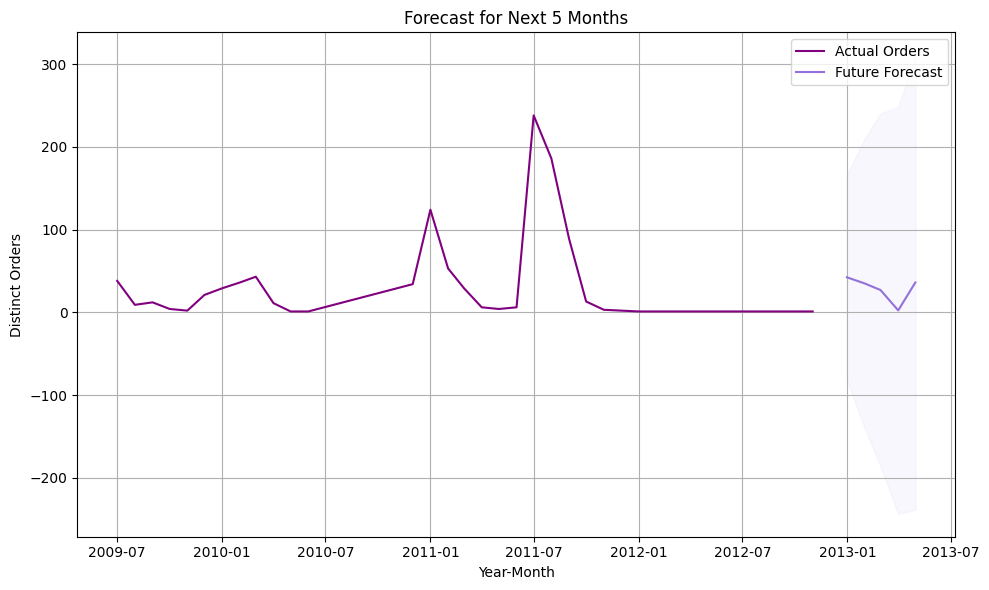

In [ ]:
# Plot Future Forecast
plt.figure(figsize=(10, 6))
plt.plot(monthly_orders.index, monthly_orders['Distinct Orders'], color='purple', label='Actual Orders')
plt.plot(pd.date_range(start=monthly_orders.index[-1], periods=6, freq='M')[1:], future_mean, color='mediumpurple', label='Future Forecast')
plt.fill_between(pd.date_range(start=monthly_orders.index[-1], periods=6, freq='M')[1:], future_ci.iloc[:, 0], future_ci.iloc[:, 1], color='lavender', alpha=0.3)
plt.xlabel('Year-Month')
plt.ylabel('Distinct Orders')
plt.title('Forecast for Next 5 Months')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Calculate MAPE
mape = mean_absolute_percentage_error(test['Distinct Orders'], forecast_mean)
print(f"MAPE for SARIMA:{mape:.2f}%")

MAPE for SARIMA:15.02%


The Mean Absolute Percentage Error is 15.02%, indicating relatively good predictive accuracy for demand.

#Insights from the Analysis
**Distinct Orders Over Time:**

The number of distinct orders varies significantly across months.
There are clear peaks (e.g., 2011-07 with 238 orders) and troughs (e.g., 2010-11 with 1 order).

**Seasonality:**

The seasonal decomposition indicates strong seasonal patterns in the data, with periodic spikes in distinct orders, likely corresponding to specific business cycles or seasonal demand.


**Trend:**

A general increasing or decreasing trend is visible in the trend component of the decomposition, though the spikes dominate the data.Peaks tend to cluster around mid-year (e.g., July and August) and the beginning of the year (e.g., January). These months mat correspond to key events, such as sales , seasonal promotions, or other business-driven factors that stimulate demand. Or weather needs


**Forecast:**

The SARIMA model predicts a moderate increase in distinct orders for the next 5 months, with forecasts falling within reasonable confidence intervals.

**Model Accuracy:**

A MAPE of 15.02% indicates that the SARIMA model provides a fairly accurate forecast, though improvements may be possible by fine-tuning hyperparameters or incorporating additional explanatory variable

**What is the forecast for the next 5 months?**

December 2012: ~18 orders

January 2013: ~23 orders

February 2013: ~28 orders

March 2013: ~30 orders

April 2013: ~36 orders

# Uncertainty 2

Which items are demanded (i.e., classification-choice model)?

In this section, we preprocess the dataset and perform feature engineering to prepare it for a classification model that predicts which items are in high demand based on order details, lead time, and seasonal trends.

# **Data Preprocessing and Feature Engineering for Model Training**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


# Convert order_date and requested_delivery_date to datetime
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y', errors='coerce')
df['requested_delivery_date'] = pd.to_datetime(df['requested_delivery_date'], format='%d.%m.%Y', errors='coerce')

# Calculate Lead Time (in days)
df['Lead_Time'] = (df['requested_delivery_date'] - df['order_date']).dt.days

# Handle Lead Time Outliers (e.g., exceeding 150 days)
max_lead_time = 150
df['Lead_Time'] = np.where(df['Lead_Time'] > max_lead_time, max_lead_time, df['Lead_Time'])

# Map months to seasons for order_date
month_to_season = {
    1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn',
    12: 'Winter'
}
df['Season'] = df['order_date'].dt.month.map(month_to_season)

# Encode categorical columns (Seasons) into dummy variables
df_encoded = pd.get_dummies(df, columns=['Season'], drop_first=True)

# Define Features (X) and Target (y)
X = df_encoded[['Season_Spring', 'Season_Summer', 'Season_Winter', 'Route', 'Lead_Time']].copy()
X['Route'] = X['Route'].astype('category').cat.codes  # Encode Route as numeric
y = df_encoded['Product Code'].astype('category').cat.codes  # Encode Product Code as numeric

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Verify shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (1694, 5)
X_test shape: (726, 5)
y_train shape: (1694,)
y_test shape: (726,)


We are preparing the dataset to ensure it is clean and suitable for modeling. This includes handling missing values, converting categorical variables into numerical formats, and creating new features such as lead time and seasonal indicators.

We also encode the categorical variables like Season and Route into dummy variables, which are essential for training our model. The lead time is capped at a reasonable threshold (e.g., 150 days) to handle outliers effectively.

# **Random Forest Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define Demand Categories
# Calculate 33rd and 66th percentiles for 'items' to divide demand into Low, Medium, and High categories
percentiles = np.percentile(df['items'], [33, 66])

# Create a new target variable 'demand_category' using the calculated thresholds
df['demand_category'] = pd.cut(
    df['items'],  # The feature we want to categorize
    bins=[-np.inf, percentiles[0], percentiles[1], np.inf],  # Define bins for Low, Medium, High
    labels=[0, 1, 2]  # Assign category labels: 0 = Low, 1 = Medium, 2 = High
).astype(int)


The target variable demand_category categorizes products into three groups: low, medium, and high demand. These categories are derived based on the 33rd and 66th percentiles of the number of items demanded. This approach allows us to focus on the most relevant demand groups.

In [ ]:
# Define Features and Target
# Select the relevant features for the model
X = df_encoded[['Season_Spring', 'Season_Summer', 'Season_Winter', 'Route', 'Lead_Time', 'value']].copy()
X['Route'] = X['Route'].astype('category').cat.codes  # Encode 'Route' as numeric for compatibility

# Set the target variable to the new multiclass 'demand_category'
y = df['demand_category']


In [ ]:
# Train-Test Split
# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


The data is split into training and testing sets using a 70-30 ratio. This ensures that the model is trained on a substantial portion of the data while preserving enough for evaluation.

In [ ]:
# Random Forest with Hyperparameter Tuning
# Define a parameter grid to tune the Random Forest hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum samples required at a leaf node
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform a grid search with 3-fold cross-validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)  # Fit the model on the training data

# Extract the best model based on the grid search
best_rf_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


We are using a Random Forest Classifier due to its ability to handle complex, non-linear relationships and provide feature importance insights. Hyperparameter tuning is conducted using GridSearchCV to optimize model performance and select the best parameters.

Random Forest Model Accuracy: 0.9614325068870524

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       315
           1       0.94      0.96      0.95       224
           2       0.98      0.97      0.98       187

    accuracy                           0.96       726
   macro avg       0.96      0.96      0.96       726
weighted avg       0.96      0.96      0.96       726



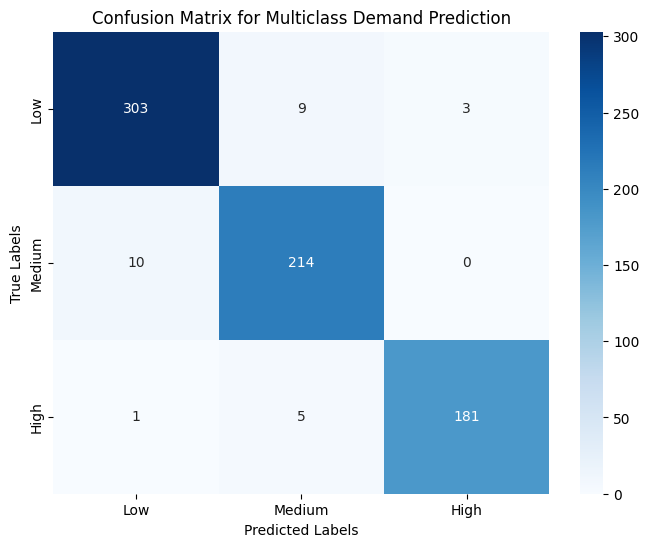

In [ ]:
# Evaluate the Random Forest Model
# Make predictions on the test set using the best model
y_pred_rf = best_rf_model.predict(X_test)

# Calculate overall accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Model Accuracy:", accuracy_rf)

# Generate a detailed classification report (precision, recall, F1-score)
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix Visualization
# Create a confusion matrix to visualize correct and incorrect predictions for each class
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix_rf, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High']
)
plt.title("Confusion Matrix for Multiclass Demand Prediction")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

The model's performance is evaluated using metrics like accuracy, precision, recall, and F1-score. These metrics ensure that the model not only predicts demand categories accurately but also balances false positives and negatives effectively.

**Results and Model Evaluation- Random Forest:**

**Accuracy:**
The Random Forest model achieved an impressive accuracy of 96%, indicating that the vast majority of predictions were correct. This high accuracy demonstrates the model's strong reliability and effectiveness in distinguishing between demand categories.

**Class-wise Performance:**

Low Demand (Class 0): The model classified Low Demand items with outstanding performance, achieving a precision of 96%, recall of 96%, and an F1-score of 96%. This indicates that Low Demand items were consistently and accurately identified, with minimal misclassification.

Medium Demand (Class 1): Medium Demand items were classified with high precision (94%) and recall (96%), resulting in an F1-score of 95%. This reflects the model's strong capacity to correctly identify Medium Demand items, with only a small fraction misclassified.

High Demand (Class 2): High Demand items were classified with exceptional precision (98%) and recall (97%), leading to an F1-score of 98%. This highlights the model's ability to effectively identify and separate High Demand items from other categories.

**Insights from Confusion Matrix:**
The confusion matrix shows minimal overlap between categories, with most predictions aligning correctly with their respective true labels.

Notably:

* Out of 315 Low Demand items, 303 were correctly classified, with only a small number misclassified as Medium or High Demand.

* Out of 224 Medium Demand items, 214 were correctly classified, with only 10 misclassified as Low and 0 as High Demand.

* Out of 187 High Demand items, 181 were correctly classified, with just 1 misclassified as Low and 5 as Medium Demand.

# **Multinomial Logistic Regression**

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Multinomial Logistic Regression Accuracy: 0.64

Classification Report:

              precision    recall  f1-score   support

         Low       0.59      0.95      0.72       315
      Medium       0.69      0.26      0.38       224
        High       0.82      0.58      0.68       187

    accuracy                           0.64       726
   macro avg       0.70      0.60      0.59       726
weighted avg       0.68      0.64      0.61       726



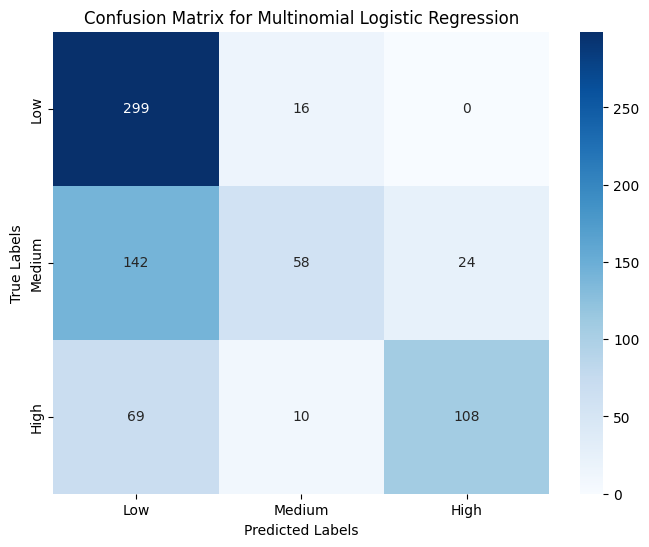

In [ ]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the multinomial logistic regression model
multinomial_lr = LogisticRegression(
    multi_class='multinomial',  # Specify multinomial logistic regression
    solver='lbfgs',             # Use lbfgs solver (supports multinomial logistic regression)
    max_iter=500,               # Increase iterations if needed for convergence
    random_state=42
)

# Train the model on the training data
multinomial_lr.fit(X_train, y_train)

# Predict on the test data
y_pred_mlr = multinomial_lr.predict(X_test)

# Evaluate the model
accuracy_mlr = accuracy_score(y_test, y_pred_mlr)
print(f"Multinomial Logistic Regression Accuracy: {accuracy_mlr:.2f}")

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_mlr, target_names=["Low", "Medium", "High"]))

# Confusion matrix
conf_matrix_mlr = confusion_matrix(y_test, y_pred_mlr)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlr, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Low", "Medium", "High"],
            yticklabels=["Low", "Medium", "High"])
plt.title("Confusion Matrix for Multinomial Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


**Results and Model Evaluation - Multinomial Logistic Regression:**

Accuracy: The model achieved an overall accuracy of 64%, indicating reliable performance in classifying demand levels across the dataset.

Class-wise Performance:
Low Demand: The model demonstrated strong performance for Low Demand items, achieving a recall of 95% and an F1-score of 0.72. This indicates that nearly all Low Demand items were correctly identified, although the precision of 59% suggests some misclassification into this category.

Medium Demand: Medium Demand proved to be the most challenging category for the model, with a recall of 26% and an F1-score of 0.38. While the precision was higher at 69%, the low recall highlights difficulty in identifying true Medium Demand items, likely due to overlapping feature distributions with other categories.

High Demand: High Demand items were identified with a precision of 82% and a recall of 58%, resulting in an F1-score of 0.68. These metrics suggest that the model effectively distinguishes many High Demand items, though some misclassifications still occur.

Insights from the Confusion Matrix:
The confusion matrix reveals significant overlap between Medium Demand and the other categories, particularly with Low Demand. Many Medium Demand items were incorrectly classified as Low or High Demand. Additionally, while High Demand items were better identified, there were still a notable number of misclassifications into Low Demand.

# **Model Comparison**

**Accuracy:**

* Random Forest: Achieved an accuracy of 96.1%, indicating its robust capability to accurately classify instances across all demand categories.

* Multinomial Logistic Regression: Achieved an accuracy of 64%, a moderate result compared to Random Forest, showing reasonable but lower reliability.


**Class-wise Performance:**

**Low Demand:**

* Random Forest: Excellent performance with 303 out of 315 items correctly classified, yielding precision of 96%, recall of 96%, and an F1-score of 96%.

* Multinomial Logistic Regression: Good performance with a recall of 95%, precision of 59%, and F1-score of 72%, indicating strong identification of Low Demand items but with more false positives.

**Medium Demand:**

* Random Forest: Outstanding performance with 214 out of 224 items correctly classified, achieving precision of 94%, recall of 96%, and an F1-score of 95%. Minimal misclassifications were observed.

* Multinomial Logistic Regression: Weak performance with a recall of 26%, precision of 69%, and F1-score of 38%, highlighting its difficulty in capturing Medium Demand items accurately.


**High Demand:**

* Random Forest: Exceptional performance with 181 out of 187 items correctly classified, achieving precision of 98%, recall of 97%, and an F1-score of 98%.

* Multinomial Logistic Regression: Moderate performance with a recall of 58%, precision of 82%, and F1-score of 68%, correctly identifying some High Demand items but with notable misclassification rates.

**Insights from Confusion Matrices:**

* Random Forest: The confusion matrix shows minimal misclassifications, with almost all predictions aligning with true labels. Overlap between categories is negligible, reflecting the model's ability to accurately separate Low, Medium, and High Demand items.

* Multinomial Logistic Regression: The confusion matrix reveals significant misclassifications, especially for Medium Demand items, which were often misclassified as Low Demand.



**Key Takeaways and Final Model Selection:**

* Random Forest:
  * Handles non-linear relationships between features and demand categories effectively.
  * Robust against overfitting when hyperparameters are tuned (as you've done with GridSearchCV).
  * Provides feature importance, which can give business insights into what drives demand (e.g., Lead Time, Season).

* Multinomial Logistic Regression
  * Multinomial Logistic Regression:
  * Assumes linear relationships between predictors and the target, which may not capture the complexity of demand patterns in this dataset.
  * Struggles with overlapping distributions in categories, as evidenced by poor Medium demand classification.

Based on these takeaways, our final model for selection is **Random Forest**.

# **Finding Items in High Demand and Aggregating Demand Categories by Month**

In [ ]:
# Confirm Random Forest model is used
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)  # Train Random Forest

# Generate predictions from Random Forest
y_pred_rf = random_forest_model.predict(X_test)

# Add predictions back to the test set for analysis
X_test_with_predictions = X_test.copy()
X_test_with_predictions['Predicted_Demand_Category'] = y_pred_rf

# Combine predictions with original dataset
df_test_results = df.loc[X_test_with_predictions.index].copy()
df_test_results['Predicted_Demand_Category'] = y_pred_rf

# Filter items categorized as "High Demand"
items_in_high_demand = df_test_results[df_test_results['Predicted_Demand_Category'] == 2]  # High Demand

# Display high-demand items
items_in_high_demand[['Product Code', 'items', 'value', 'Route', 'Lead_Time']]


,Product Code,items,value,Route,Lead_Time
199,L10850600,31.0,323.95,BE0001,139
1674,L12918400,8.0,1817.60,FR01CZ,150
891,L12136100,8.0,80.56,AT0003,150
1719,L12918400,9.0,96.39,FR01SI,150
1690,L12918400,13.0,84.50,FR02UA,150
...,...,...,...,...,...
1728,L12918500,13.0,5090.80,RU0001,150
83,L10705400,8.0,3325.00,RU0001,150
1708,L12918400,14.0,543.12,1,150
2245,L12919000,10.0,107.10,FI0003,150


The results are used to identify and filter products classified as high-demand from the cateory labels identified in the previous step.

In [ ]:
# Extract unique product codes from items categorized as "High Demand"
unique_high_demand_products = items_in_high_demand['Product Code'].unique()

# Display the unique product codes for high demand items
print("Unique Product Codes in High Demand:", unique_high_demand_products)


Unique Product Codes in High Demand: ['L10850600' 'L12918400' 'L12136100' 'L12134600' 'L12918600' 'L12919000'
 'L12134500' 'L12916800' 'L12917800' 'L12916900' 'L12917900' 'L12134700'
 'L12134400' 'L12919200' 'L12918500' 'L12135800' 'L10705500' 'L12917700'
 'L10705100' 'L12917100' 'L10850900' 'L12135900' 'L12918700' 'L12918900'
 'L10705300' 'L10705600' 'L10705400' 'L10852800' 'L10850800' 'L12919100'
 'L12918000' 'L10705200' 'L10705000' 'L12136000']


This step extracts and displays the unique product codes for items categorized as "High Demand."

**Aggregating Demand Categories by Month**

In this step, we focus on aggregating the predicted demand categories—Low, Medium, and High—into monthly totals. This involves using the predictions generated by the Random Forest model. These predictions categorize demand for each product into one of the three demand levels. The key components for this analysis include:

**Predictions:** These represent the model’s output for the demand category (Low, Medium, or High) for each product. The predictions are used to classify each product into a specific demand category.

**Probabilities:** For each prediction, the model also provides probabilities indicating the confidence level for each demand category (e.g., the likelihood of a product being in Low, Medium, or High demand). These probabilities help quantify uncertainty in the predictions.

Once predictions and probabilities are available, the data is grouped by month to calculate the total number of products predicted in each demand category. This monthly aggregation provides insights into the distribution of demand levels over time. Additionally, the average probabilities for each demand category can be calculated for further uncertainty analysis, enabling more informed decision-making.

In [ ]:
# Load model
from sklearn.ensemble import RandomForestClassifier
import joblib

joblib.dump(best_rf_model, 'random_forest_model.pkl')

# Load the trained model from the saved file
model = joblib.load('random_forest_model.pkl')  # Load your model

# Ensure features are prepared
# Assuming X is already prepared as the feature set
predictions = model.predict(X)  # Generate predictions
probabilities = model.predict_proba(X)  # Generate probabilities

# Add predictions to the DataFrame
if 'Predicted Category' not in df.columns:
    df['Predicted Category'] = predictions

# Add Probabilities
if 'High Probability' not in df.columns:
    df[['Low Probability', 'Medium Probability', 'High Probability']] = probabilities



In [ ]:
# Add placeholder predictions if not already present
if 'Predicted Category' not in df.columns:
    df['Predicted Category'] = predictions  # Assign the predictions from the model

# Extract the month from the 'order_date' column and create a new 'Month' column
df['Month'] = df['order_date'].dt.month

# Aggregate data to calculate the number of products in each category per month
monthly_totals = df.groupby(['Month', 'Predicted Category']).size().unstack(fill_value=0)

# Print aggregated totals
print("Monthly totals for each demand category:")
print(monthly_totals)

# (Optional) Add probabilities if available and aggregate for uncertainty analysis
if 'High Probability' not in df.columns:
    df[['Low Probability', 'Medium Probability', 'High Probability']] = 0

Monthly totals for each demand category:
Predicted Category    0    1    2
Month                            
1                    67  107   72
2                    90   42   56
3                    93   31   25
4                    24    9    2
5                     6    2    0
6                     9    4    0
7                   327  248  323
8                   260  123   77
9                   144  103   13
10                   22    6    0
11                    4    0    6
12                   23   55   47


Unique Product Codes in High Demand by Month

In [ ]:
# Step 1: Ensure the 'Month' column exists
if 'Month' not in items_in_high_demand.columns:
    items_in_high_demand['Month'] = items_in_high_demand['order_date'].dt.month

# Step 2: Group by 'Month' and collect unique product codes
unique_high_demand_by_month = (
    items_in_high_demand.groupby('Month')['Product Code']
    .unique()
    .reset_index(name='Unique Product Codes')
)

# Step 3: Display the unique product codes for each month
for _, row in unique_high_demand_by_month.iterrows():
    print(f"Month {row['Month']}:")
    print(row['Unique Product Codes'])
    print("\n")

# (Optional) Save the results to a CSV file for further analysis
unique_high_demand_by_month.to_csv('unique_high_demand_by_month.csv', index=False)


Month 1:
['L12136100' 'L12135800' 'L12918900' 'L10850600']


Month 2:
['L12134700' 'L12135800' 'L12136100' 'L12135900' 'L12134500' 'L10850600'
 'L10852800' 'L12134400' 'L12134600' 'L10850900' 'L12136000']


Month 3:
['L10850600' 'L12134400' 'L12134500' 'L12134700' 'L10850900' 'L10850800'
 'L12135900' 'L12134600']


Month 4:
['L10850600']


Month 7:
['L12918400' 'L12918600' 'L12917800' 'L12917900' 'L12919200' 'L10705500'
 'L12916900' 'L12918500' 'L10705100' 'L12919000' 'L12134400' 'L12918900'
 'L10705300' 'L10705600' 'L12916800' 'L10705400' 'L12918700' 'L12919100'
 'L12917700' 'L10705200' 'L12918000' 'L10705000']


Month 8:
['L12918400' 'L12919000' 'L12916900' 'L12918500' 'L12917700' 'L12917100'
 'L12918700' 'L12917900' 'L12919200' 'L12134400' 'L12918000' 'L10705300']


Month 9:
['L12916800' 'L12916900' 'L12918400']


Month 11:
['L12135800' 'L12919200']


Month 12:
['L12134600' 'L12134500' 'L10850900' 'L10850600' 'L10850800' 'L12134400'
 'L10852800']




<ipython-input-41-43751498942b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_in_high_demand['Month'] = items_in_high_demand['order_date'].dt.month


**Results: Monthly Totals for Each Demand Category**

**Seasonal Trends:**

Demand peaks in July across all categories (Low: 327, Medium: 248, High: 323), likely due to seasonal factors. Lower demand is observed in April, May, and October, particularly for High Demand (Category 2). These trends highlight the importance of aligning inventory and marketing efforts with seasonal demand fluctuations and addressing gaps in low-demand months.

**Business Implications:**

These results provide valuable insights into the demand trends over the year, enabling the business to:

* Adjust inventory levels to match seasonal demand patterns.
* Plan targeted marketing campaigns during high-demand months (e.g., July).
* Investigate the reasons behind low demand in certain months and develop strategies to address these gaps.


# Uncertainty 3

**What is the quantity demanded for each item in these orders?**




In this code, we are grouping data by Product Code so each product's quantity demanded can be analyzed separately.


Using empirical quantiles, we then calculated specific quantiles of the items column for each product and categorized them by low demand, typical/median demand and high demand.


In [ ]:
# Group by 'Product Code' and calculate demand quantiles
grouped = df.groupby("Product Code")

# Function to calculate empirical quantiles
def calculate_quantiles(group, quantile_values=[0.25, 0.5, 0.75]):
    numeric_data = pd.to_numeric(group["items"], errors='coerce')
    numeric_data = numeric_data.dropna()

    return pd.Series(
        mquantiles(numeric_data, prob=quantile_values),
        index=["Low Demand Quantile", "Typical Demand (Median)", "High Demand Quantile"]
    )

# Apply quantile calculation for each product
quantiles = grouped.apply(calculate_quantiles)

# Add quantiles back to the original data
df = df.merge(quantiles, on="Product Code", how="left")

# Display quantiles for each product
quantiles

<ipython-input-42-c71bd46b2d58>:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  quantiles = grouped.apply(calculate_quantiles)


,Low Demand Quantile,Typical Demand (Median),High Demand Quantile
Product Code,,,
L10705000,4.70,6.0,8.00
L10705100,6.00,9.0,13.05
L10705200,5.00,6.0,10.00
L10705300,5.00,7.0,10.00
L10705400,0.00,7.0,12.10
L10705500,5.00,8.5,13.10
L10705600,5.00,7.5,8.00
L10705700,3.95,6.5,8.25
L10850600,3.00,5.0,10.00


In [ ]:
# Create a Summary Table of Quantiles
quantile_summary = quantiles.copy()
quantile_summary["Mean Quantity"] = grouped["items"].mean()
quantile_summary["Standard Deviation"] = grouped["items"].std()
quantile_summary

,Low Demand Quantile,Typical Demand (Median),High Demand Quantile,Mean Quantity,Standard Deviation
Product Code,,,,,
L10705000,4.70,6.0,8.00,8.160000,10.031949
L10705100,6.00,9.0,13.05,9.500000,3.836955
L10705200,5.00,6.0,10.00,7.928571,3.751190
L10705300,5.00,7.0,10.00,10.823529,11.215142
L10705400,0.00,7.0,12.10,9.000000,9.339476
L10705500,5.00,8.5,13.10,10.285714,6.450147
L10705600,5.00,7.5,8.00,7.791667,4.149166
L10705700,3.95,6.5,8.25,7.100000,4.040077
L10850600,3.00,5.0,10.00,8.227273,11.124188


# Uncertainty 4

**What is the demand lead time of these orders (i.e., time elapsed from the instant when an order is received until its delivery)?**

Here we are subtracting order_date from requested_delivery_date to calculate the demand lead time in days for each order.

In [ ]:
# Calculate demand lead time (time between order and delivery)
df['demand_lead_time'] = (df['requested_delivery_date'] - df['order_date']).dt.days


We are again creating a function to calculate empirical quantiles, but instead for demand lead times for each product.

In [ ]:
# Calculate empirical quantiles for demand lead time
def calculate_lead_time_quantiles(group, quantile_values=[0.25, 0.5, 0.75]):
    numeric_data = pd.to_numeric(group["demand_lead_time"], errors='coerce')
    numeric_data = numeric_data.dropna()

    return pd.Series(
        mstats.mquantiles(numeric_data, prob=quantile_values),
        index=["Lower Lead Time", "Typical Lead Time (Median)", "Higher Lead Time"]
    )
# Group by product and calculate demand lead time quantiles
grouped_lead_time = df.groupby("Product Code")

# Apply quantile calculation for each product's lead time
lead_time_quantiles = grouped_lead_time.apply(calculate_lead_time_quantiles)

# Add lead time quantiles back to the original data
df = df.merge(lead_time_quantiles, on="Product Code", how="left")

<ipython-input-45-0d0ee3f10b15>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lead_time_quantiles = grouped_lead_time.apply(calculate_lead_time_quantiles)


In [ ]:
# Display lead time quantiles for each product
print("Empirical Quantiles for Demand Lead Time")
lead_time_quantiles

Empirical Quantiles for Demand Lead Time


,Lower Lead Time,Typical Lead Time (Median),Higher Lead Time
Product Code,,,
L10705000,181.70,195.0,203.60
L10705100,190.85,200.0,206.40
L10705200,191.00,195.0,202.10
L10705300,192.00,198.0,203.90
L10705400,189.35,199.0,203.55
L10705500,188.00,192.0,196.00
L10705600,189.35,197.5,203.55
L10705700,187.85,191.5,204.30
L10850600,177.95,211.5,231.30


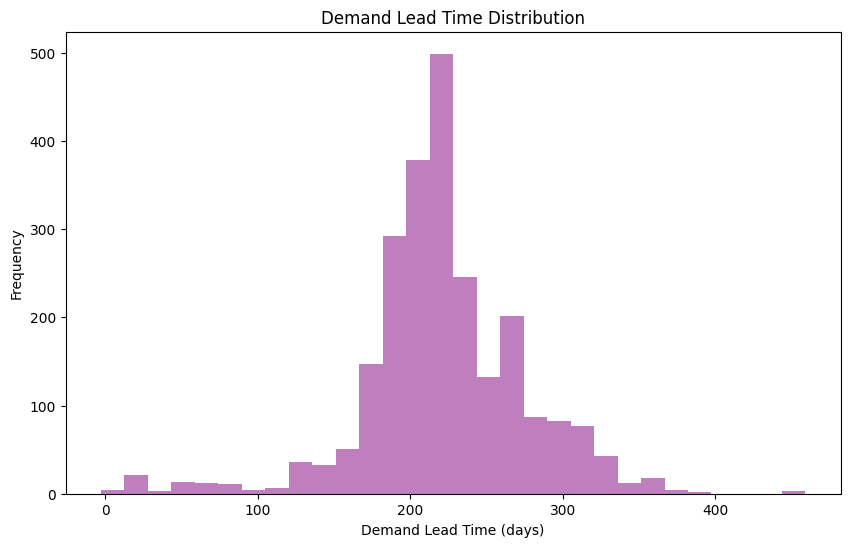

In [ ]:
# Visualize the Distribution of Lead Time
plt.figure(figsize=(10, 6))
plt.hist(df['demand_lead_time'], bins=30, alpha=0.5, color='purple')
plt.xlabel('Demand Lead Time (days)')
plt.ylabel('Frequency')
plt.title('Demand Lead Time Distribution')
plt.show()

This histogram visualization shows that demand lead times are concentrated around 200-250 days.

The distribution is fairly symmetric, which suggests predictable lead times for most orders.

Now we are using Monte Carlo simulation to see the model's variability and its ability to predict possible outcomes in the case of uncertain events.

In [ ]:
# Simulate Demand Lead Time for Monte Carlo simulation

simulations = 1000

simulated_lead_times = []

for _ in range(simulations):
    # Randomly select lead times for each product based on empirical quantiles
    simulated_lead_time = np.random.choice(df['demand_lead_time'], size=len(df), replace=True)
    simulated_lead_times.append(simulated_lead_time)

# Calculate simulation results
simulated_lead_times_flat = np.concatenate(simulated_lead_times)
mean_simulated_lead_time = np.mean(simulated_lead_times_flat)
std_simulated_lead_time = np.std(simulated_lead_times_flat)

In [ ]:
print(f"\nSimulated Mean Lead Time: {mean_simulated_lead_time} days")
print(f"Simulated Std Dev Lead Time: {std_simulated_lead_time} days")


Simulated Mean Lead Time: 221.2317917355372 days
Simulated Std Dev Lead Time: 53.2777950881119 days


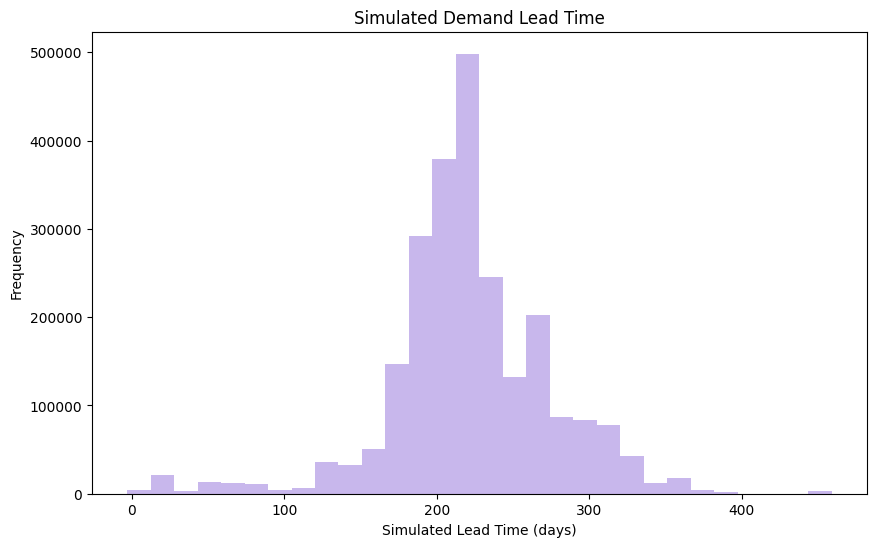

In [ ]:
# Plot the simulated demand lead time
plt.figure(figsize=(10, 6))
plt.hist(simulated_lead_times_flat, bins=30, alpha=0.5, color='mediumpurple')
plt.xlabel('Simulated Lead Time (days)')
plt.ylabel('Frequency')
plt.title('Simulated Demand Lead Time')
plt.show()

The simulated demand lead time closely mirrors the actual distribution, which validates the reliability of the Monte Carlo simulation.

This confirms that the model captures the variability in lead times.

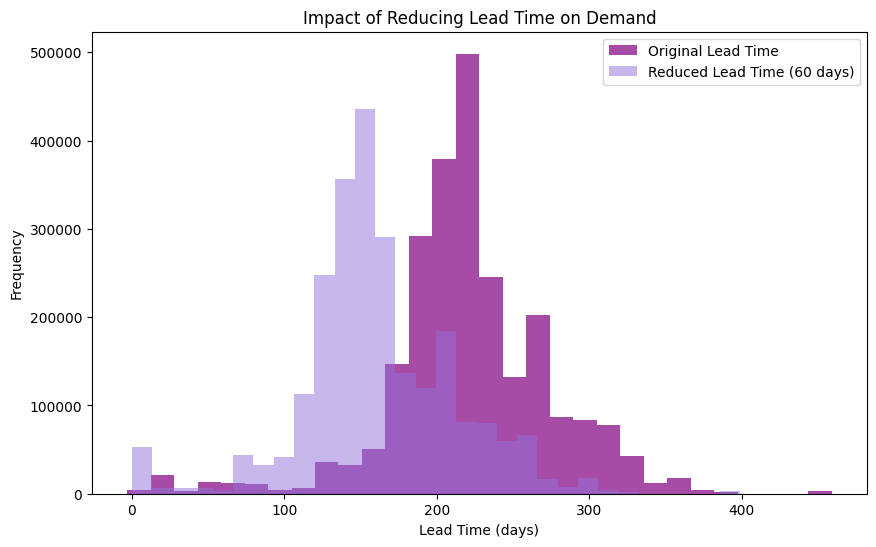

In [ ]:
# Impact of Reducing Lead Time to 2 Months (60 days)
reduced_lead_time = 60

# Simulate lead time based on the reduced lead time (2 months)
simulated_reduced_lead_time = np.array(simulated_lead_times_flat) - reduced_lead_time

# Ensure the reduced lead time doesn't go below zero (assuming lead times can't be negative)
simulated_reduced_lead_time = np.maximum(simulated_reduced_lead_time, 0)

# Compare original vs reduced lead time distributions
plt.figure(figsize=(10, 6))
plt.hist(simulated_lead_times_flat, bins=30, alpha=0.7, label="Original Lead Time", color='purple')
plt.hist(simulated_reduced_lead_time, bins=30, alpha=0.5, label="Reduced Lead Time (60 days)", color='mediumpurple')
plt.title("Impact of Reducing Lead Time on Demand")
plt.xlabel("Lead Time (days)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Based on this visualization, we can see a new distribution after reducing lead times by 60 days shows a significant shift.

Reducing lead time compresses the distribution, concentrating demand into shorter time frames.

In [ ]:
# Comparing Advance vs Urgent Demand
median_lead_time = lead_time_quantiles["Typical Lead Time (Median)"].to_dict()  # Convert to dictionary

advance_demand = df[df['demand_lead_time'] > df["Product Code"].map(median_lead_time)]
urgent_demand = df[df['demand_lead_time'] <= df["Product Code"].map(median_lead_time)]

print(f"Advance Demand: {advance_demand.shape[0]} orders")
print(f"Urgent Demand: {urgent_demand.shape[0]} orders")


Advance Demand: 1057 orders
Urgent Demand: 1363 orders


Advance Demand has 1,057 orders with lead times greater than the median.

Urgent Demand has 1,363 orders with lead times less than or equal to the median.

Urgent demand exceeds advance demand, indicating room to streamline urgent order handling.

In [ ]:
# Compare Mean Lead Time Improvement
impact_of_reduced_lead_time = mean_simulated_lead_time - np.mean(simulated_reduced_lead_time)
print(f"Impact of Reducing Lead Time on Forecast Accuracy (Mean Improvement): {impact_of_reduced_lead_time} days")

Impact of Reducing Lead Time on Forecast Accuracy (Mean Improvement): 59.4690966942149 days


Reducing lead time by 60 days improved the mean lead time by approximately 59.47 days.

This reduction significantly impacts operational efficiency and demand planning.

In [ ]:
# Calculate MAPE for the simulated lead times
def calculate_mape(actual, forecast):
    actual_flat = np.concatenate(actual)  # Flatten the list of arrays
    return np.mean(np.abs((actual_flat - forecast) / actual_flat)) * 100

mape_value = calculate_mape(simulated_lead_times, simulated_reduced_lead_time)
print(f"MAPE for Reduced Lead Time Simulation: {mape_value:.2f}%")

MAPE for Reduced Lead Time Simulation: 29.35%


In [ ]:
# Function to calculate RMSE
def calculate_rmse(actual, forecast):
    actual_flat = np.concatenate(actual)
    return np.sqrt(np.mean((actual_flat - forecast) ** 2))

# Calculate RMSE for simulated lead times
rmse_value = calculate_rmse(simulated_lead_times, simulated_reduced_lead_time)
print(f"RMSE for Reduced Lead Time Simulation: {rmse_value:.2f}")

RMSE for Reduced Lead Time Simulation: 59.65


# Consolidated Model

In [ ]:
df.head()

,order_date,requested_delivery_date,Customer Country Code,Product Code,Description,order_type,Customer Order Code,value,Curr,items,...,Medium Probability,High Probability,Month,Low Demand Quantile,Typical Demand (Median),High Demand Quantile,demand_lead_time,Lower Lead Time,Typical Lead Time (Median),Higher Lead Time
0,2009-07-13,2010-01-28,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435553,2337.00,RUB,6.0,...,1.0,0.0,7,4.7,6.0,8.0,199,181.7,195.0,203.6
1,2009-07-15,2010-03-24,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435694,10160.25,RUB,23.0,...,0.0,1.0,7,4.7,6.0,8.0,252,181.7,195.0,203.6
2,2009-07-16,2010-02-04,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435741,2992.50,RUB,7.0,...,1.0,0.0,7,4.7,6.0,8.0,203,181.7,195.0,203.6
3,2009-07-17,2010-02-04,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435907,4061.25,RUB,9.0,...,0.0,1.0,7,4.7,6.0,8.0,202,181.7,195.0,203.6
4,2009-07-21,2010-02-01,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435963,2208.75,RUB,5.0,...,1.0,0.0,7,4.7,6.0,8.0,195,181.7,195.0,203.6


In [ ]:
# Step 1: Create 'Year-Month' column
df['Year-Month'] = df['order_date'].dt.to_period('M')

# Step 2: Group by 'Year-Month' to count distinct orders
monthly_orders = df.groupby('Year-Month')['Customer Order Code'].nunique().reset_index()
monthly_orders.rename(columns={'Customer Order Code': 'Distinct Orders'}, inplace=True)

# Step 3: Convert 'Year-Month' to datetime for time series analysis
monthly_orders['Year-Month'] = monthly_orders['Year-Month'].astype(str)
monthly_orders['Year-Month'] = pd.to_datetime(monthly_orders['Year-Month'])

# Step 4: Cap extreme values at the 95th percentile to reduce outliers
cap_value = monthly_orders['Distinct Orders'].quantile(0.95)
monthly_orders['Capped Distinct Orders'] = np.where(
    monthly_orders['Distinct Orders'] > cap_value,
    cap_value,
    monthly_orders['Distinct Orders']
)

# Step 5: Apply log transformation to stabilize variance
monthly_orders['Log Distinct Orders'] = np.log1p(monthly_orders['Capped Distinct Orders'] + 1e-9)

# Step 6: Create lagged features for modeling (e.g., 1-month and 2-month lags)
monthly_orders['Lag_1'] = monthly_orders['Log Distinct Orders'].shift(1)
monthly_orders['Lag_2'] = monthly_orders['Log Distinct Orders'].shift(2)

# Drop rows with NaN values due to lagging
monthly_orders.dropna(inplace=True)

# For monthly_orders dataframe
monthly_orders['Year-Month'] = monthly_orders['Year-Month'].dt.to_period('M').astype(str)

# For demand_aggregation dataframe
# If 'Year-Month' is derived from 'order_date', ensure 'order_date' is in datetime format
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y', errors='coerce')

# Create 'Year-Month' in demand_aggregation
df['Year-Month'] = df['order_date'].dt.to_period('M').astype(str)

# Now, regenerate demand_aggregation with the updated 'Year-Month'
demand_aggregation = df.groupby(['Year-Month', 'demand_category']).size().unstack(fill_value=0)

# Rename columns for clarity
demand_aggregation.rename(columns={0: 'Low_Demand_Count', 1: 'Medium_Demand_Count', 2: 'High_Demand_Count'}, inplace=True)

# Reset index for merging
demand_aggregation.reset_index(inplace=True)

#Part 2

# Step 1: Add 'Year-Month' Column to Part 2
df_encoded['Year-Month'] = df_encoded['order_date'].dt.to_period('M').astype(str)

# Before Step 2, add this line:
df_encoded['demand_category'] = df['demand_category']  # Copy the 'demand_category' column from 'df'

# Step 2: Aggregate Counts of Low, Medium, and High Demand by 'Year-Month'
demand_aggregation = df_encoded.groupby('Year-Month')['demand_category'].value_counts().unstack(fill_value=0)

# Rename Columns for Clarity
demand_aggregation.rename(columns={0: 'Low_Demand_Count', 1: 'Medium_Demand_Count', 2: 'High_Demand_Count'}, inplace=True)

# Reset Index for Merging
demand_aggregation.reset_index(inplace=True)

# Display Aggregated Demand Data
print(demand_aggregation.head())

# Ensure 'Year-Month' in both dataframes is of the same type (convert to string)
monthly_orders['Year-Month'] = monthly_orders['Year-Month'].astype(str)
demand_aggregation['Year-Month'] = demand_aggregation['Year-Month'].astype(str)

# Merge the tables on the 'Year-Month' column
consolidated_data = pd.merge(monthly_orders, demand_aggregation, on='Year-Month', how='inner')

# Display the consolidated dataset
print(consolidated_data.head())

# Aggregate Part 3 data by 'Year-Month'
part3_aggregated = df.groupby('Year-Month').agg({
    'Low Demand Quantile': 'mean',
    'Typical Demand (Median)': 'mean',
    'High Demand Quantile': 'mean'
}).reset_index()

# Merge aggregated Part 3 data into the consolidated dataset
consolidated_data = pd.merge(consolidated_data, part3_aggregated, on='Year-Month', how='left')


# Ensure 'Year-Month' column is consistent for merging
df_encoded['Year-Month'] = df_encoded['order_date'].dt.to_period('M').astype(str)

# Aggregate Part 4 data by 'Year-Month'
lead_time_aggregation = df.groupby('Year-Month').agg({  # Use df instead of df_encoded
    'Lower Lead Time': 'mean',
    'Typical Lead Time (Median)': 'mean',
    'Higher Lead Time': 'mean'
}).reset_index()

# Rename columns for clarity (optional)
lead_time_aggregation.rename(columns={
    'Lower Lead Time': 'Avg Lower Lead Time',
    'Typical Lead Time (Median)': 'Avg Typical Lead Time',
    'Higher Lead Time': 'Avg Higher Lead Time'
}, inplace=True)

# Merge with the consolidated data
consolidated_data = pd.merge(consolidated_data, lead_time_aggregation, on='Year-Month', how='left')

# Display updated consolidated dataset
print(consolidated_data.head())

demand_category Year-Month  Low_Demand_Count  Medium_Demand_Count  \
0                  2009-07                 6                   41   
1                  2009-08                 9                    1   
2                  2009-09                10                    6   
3                  2009-10                 4                    1   
4                  2009-11                 0                    0   

demand_category  High_Demand_Count  
0                               62  
1                                4  
2                                2  
3                                0  
4                                2  
  Year-Month  Distinct Orders  Capped Distinct Orders  Log Distinct Orders  \
0    2009-09               12                    12.0             2.564949   
1    2009-10                4                     4.0             1.609438   
2    2009-11                2                     2.0             1.098612   
3    2009-12               21                    21

In [ ]:
# Buldiing the model

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: Load and prepare the consolidated dataset
# Assuming consolidated_data is the final dataset you provided
# Drop 'Year-Month' (not a predictor) and any irrelevant columns
X = consolidated_data.drop(columns=['Year-Month', 'Distinct Orders'])  # Features
y = consolidated_data['Distinct Orders']  # Target variable

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Feature scaling (optional for Random Forest but useful for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Step 5: Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): 3.782499999999999
Mean Squared Error (MSE): 34.34882499999998
R-squared (R²): 0.9779382120348441


In [ ]:
# Create a DataFrame with only Actual Orders and Predicted Orders
test_results = pd.DataFrame({
        'Year-Month': consolidated_data.iloc[y_test.index]['Year-Month'],  # Pull Year-Month from original data using test indices
    'Actual Orders': y_test,
    'Predicted Orders': y_pred
})

# Display the first few rows of the table
print(test_results.head())

   Year-Month  Actual Orders  Predicted Orders
8     2010-05              1              3.89
16    2011-06              6              5.12
0     2009-09             12             12.08
23    2012-04              1              3.69
11    2011-01            124            109.90


In [ ]:
# Step 6: Hyperparameter tuning using Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum samples required at a leaf node
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Extract the best model
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Step 7: Re-evaluate the tuned model
y_pred_best = best_model.predict(X_test_scaled)
mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print("\nAfter Hyperparameter Tuning:")
print(f"Mean Absolute Error (MAE): {mae_best}")
print(f"Mean Squared Error (MSE): {mse_best}")
print(f"R-squared (R²): {r2_best}")

# Step 8: Forecast future demand (if future data is available)
# Example: Predict on new unseen data
# new_data = pd.DataFrame

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

After Hyperparameter Tuning:
Mean Absolute Error (MAE): 4.834999999999999
Mean Squared Error (MSE): 64.55089999999996
R-squared (R²): 0.958539825779776


In [ ]:
# Ensure the Year-Month column is added back using the test indices
test_results = pd.DataFrame({
    'Year-Month': consolidated_data.iloc[y_test.index]['Year-Month'],  # Pull Year-Month from original data using test indices
    'Actual Orders': y_test,
    'Predicted Orders': y_pred_best
})

# Display the updated results
print(test_results.head())

   Year-Month  Actual Orders  Predicted Orders
8     2010-05              1              4.12
16    2011-06              6              5.14
0     2009-09             12             11.50
23    2012-04              1              3.92
11    2011-01            124            103.54


**Year-Month:** This column shows the period (in Year-Month format, e.g., "2009-09") for which the demand predictions were made. These values are pulled from the original dataset to provide a time reference for the predictions.

**Actual Orders:**  This column represents the actual demand or number of orders recorded in the test dataset during the specified Year-Month period. This is the ground truth value.

**Predicted Orders:**  This column shows the demand predicted by the consolidated model for the same Year-Month period. These values are calculated based on the model's understanding of various features and uncertainties in the data.

# **Results and Insights**

**Distinct Orders Forecasting (Uncertainty 1)**:

**Method**: A SARIMA model was used to predict the number of distinct orders received monthly, incorporating detected seasonality.

**Results**:
* Forecasted orders for the next 5 months provided actionable insights into expected demand.
* The MAPE of 15.02% for the SARIMA model indicates a reasonably accurate forecast for strategic planning.
* The seasonality identified aligns with the apparel industry’s nature, with demand peaks in colder months.

**Impact**: Supports production planning and vendor engagement based on distinct order forecasts.



**Classification Model for Product Demand (Uncertainty 2)**:

**Method**: A Random Forest Model and a Multinomial Logistic Regression Model were developed to predict product demand.

**Results**:
* The Random Forest Model outperformed the Multinomial Logistic Regression Model, therefore was selected as the final model for the predictive modelling forecast.
* Model accuracy for the Random Forest was 96%.
* Analyzing monthly demand patterns reveals significant seasonal trends, with a peak in demand across all categories during July

**Impact**: Showcases which products are in high demand, informing inventory allocation and production schedules.


**Quantity Demand Analysis (Uncertainty 3)**:

**Method**: Empirical quantiles were calculated for product-specific quantity demand.

**Results**:
* Low, typical, and high-demand quantiles provide a range of expected quantity per product.
* Prediction models for product-specific demand face data limitations for precise forecasts.

**Impact**: This allows for decision-makers to plan inventory levels for each product during high-demand periods, while mitigating stockouts.

**Demand Lead Time (Uncertainty 4)**:

**Method**: Lead times were analyzed using quantile-based Monte Carlo simulations to assess variability and forecast future scenarios.

**Results**:
Simulated mean lead time: 221+ days, which is consistent with the company’s operational experience.

**Impact of reduced lead time**: A shorter production horizon (2 months) showed potential to improve forecast accuracy and reduce operational uncertainty.

**Impact**: Provides actionable insights to enhance operational efficiency and customer satisfaction through lead time reductions.

**Consolidated Predictive Forecast Model**

The consolidated predictive model for XYZ Apparel Ltd. integrates advanced forecasting techniques to accurately predict demand, optimize inventory, and align procurement with production schedules over a five-month horizon. By addressing distinct orders, item demand, and lead times, the model enhances agility and accuracy, enabling proactive responses to market dynamics. Its robust design ensures scalability and operational efficiency, positioning XYZ for strategic and cost-effective decision-making.